In [1]:
%ls

dev-0.ipynb  dev-2.ipynb  dev-3.ipynb  nana-debug.log  tables-0.html  temp.py
dev-1.ipynb  dev_2.py     dev_3.py     __pycache__/    tables-1.html


In [2]:
%%writefile dev_3.py
import lxml
import lxml.html
import lxml.etree
import os
from collections import defaultdict
from graphviz import Digraph
import yaml


HIERARCHICAL = 'hierarchical'
SEQUENTIAL = 'sequential'


def open_doc(folder, filename):
    folder = os.path.abspath(folder)
    filepath = os.path.join(folder, filename)

    with open(filepath, 'r') as file:
        doc = lxml.html.fromstring(
            lxml.etree.tostring(
                lxml.html.parse(file), method='html'
            )
        )
    return doc


def html_to_dot_sequential_name(html, with_text=False):
    graph = Digraph(name='html')
    tag_counts = defaultdict(int)
    
    def add_node(html_node):
        tag = html_node.tag
        tag_sequential = tag_counts[tag]
        tag_counts[tag] += 1
        node_name = "{}-{}".format(tag, tag_sequential)
        graph.node(node_name, node_name)
        
        if len(html_node) > 0:
            for child in html_node.iterchildren():
                child_name = add_node(child)
                graph.edge(node_name, child_name)
        else:
            child_name = "-".join([node_name, "txt"])
            graph.node(child_name, html_node.text)
            graph.edge(node_name, child_name)
        return node_name
    add_node(html)
    return graph


def html_to_dot_hierarchical_name(html, with_text=False):
    graph = Digraph(name='html')
    
    def add_node(html_node, parent_suffix, brotherhood_index):
        tag = html_node.tag
        if parent_suffix is None and brotherhood_index is None:
            node_suffix = ""
            node_name = tag
        else:
            node_suffix = (
                "-".join([parent_suffix, str(brotherhood_index)]) 
                if parent_suffix else 
                str(brotherhood_index)
            )
            node_name = "{}-{}".format(tag, node_suffix)
        graph.node(node_name, node_name, path=node_suffix)
        
        if len(html_node) > 0:
            for child_index, child in enumerate(html_node.iterchildren()):
                child_name = add_node(child, node_suffix, child_index)
                graph.edge(node_name, child_name)
        else:
            child_name = "-".join([node_name, "txt"])
            child_path = "-".join([node_suffix, "txt"])
            graph.node(child_name, html_node.text, path=child_path)
            graph.edge(node_name, child_name)
        return node_name
    add_node(html, None, None)
    return graph


def html_to_dot(html, name_option='hierarchical', with_text=False):
    if name_option == SEQUENTIAL:
        return html_to_dot_sequential_name(html, with_text=with_text)
    elif name_option == HIERARCHICAL:
        return html_to_dot_hierarchical_name(html, with_text=with_text)
    else:
        raise Exception('No name option `{}`'.format(name_option))
        
        
def depth(node):
    d = 0
    while node is not None:
        d += 1
        node = node.getparent()
    return d


def serialize_distances(dictionary):
    return yaml.dump(dictionary)


def unserialize_distances(string):
    return yaml.full_load(string)

Overwriting dev_3.py


In [3]:
%load_ext autoreload
%autoreload 2
from dev_3 import (
    open_doc, html_to_dot, SEQUENTIAL, HIERARCHICAL, depth, serialize_distances, unserialize_distances
)

In [4]:
# %%writefile temp.py

from similarity.normalized_levenshtein import NormalizedLevenshtein
import lxml
import lxml.etree
from pprint import pprint
from collections import defaultdict
import datetime
import uuid

normalized_levenshtein = NormalizedLevenshtein()
TAG_NAME_ATTRIB = 'tag_name'


class MDR:
    
    MINIMUM_DEPTH = 3
    
    def __init__(self, K, verbose=False):
        self.K = K
        self.tag_counts = defaultdict(int)
        self.verbose = verbose
        
    def _debug(self, msg, tabs=0):
        if self.verbose:
            if type(msg) == str:
                print(tabs * '\t' + msg)
            else:
                pprint(msg)
            
    def __call__(self, node):
        # each tag is named sequentially 
        tag = node.tag
        tag_name = "{}-{}".format(tag, self.tag_counts[tag])
        self.tag_counts[tag] += 1
        
        self._debug(tag_name)
        
        # when in the root
        if node.getparent() is None:
            self.distances = {}
            
        node_depth = depth(node)
        
        if node_depth >= MDR.MINIMUM_DEPTH:
            # get all possible distances of the n-grams of children
            distances = self.compare_combinations(node.getchildren()) 
            
            self._debug("{} - distances".format(tag_name))
            self._debug(distances)
            
            node.set(TAG_NAME_ATTRIB, tag_name)
            self.distances[tag_name] = distances
            
        self._debug("\n\n")

        for child in node:
            self(child)
            
    def compare_combinations(self, node_list):
        if not node_list:
            return {}
        
        self._debug("in compare_combinations")
        
        distances = {}
        n = len(node_list)
        # for (i = 1; i <= K; i++)  /* start from each node */
        for i in range(1, self.K + 1):
            print('i', i)
            # for (j = i; j <= K; j++) /* comparing different combinations
            for j in range(i, self.K + 1):
                print('\tj', j)
                # if NodeList[i+2*j-1] exists then
                if (i + 2*j - 1) < n + 1:  # +1 for pythons open set notation
                    print('\tif-1 ok')
                    st = i
                    # for (k = i+j; k < Size(NodeList); k+j)
                    # for k in range(i + j, n, j):
                    for k in range(i + j, n + 1, j):
                        print('\t\tst', st)
                        print('\t\tk', k)
                        # if NodeList[k+j-1] exists then
                        if k + j - 1 < n + 1:
                            print('\t\tif-2 ok')
                            # todo: avoid recomputing strings
                            # todo: avoid recomputing edit distances
                            # todo: check https://pypi.org/project/strsim/
                            # NodeList[St..(k-1)]
                            left = (st - 1, k -1 -1)
                            print('\t\tleft', left)
                            str_left = MDR.list_nodes_to_string(node_list[left[0]:left[1]])
                            # NodeList[St..(k-1)]
                            right = (k -1, k + j -1 -1)
                            print('\t\tright', right)
                            str_right = MDR.list_nodes_to_string(node_list[right[0]:right[1]])
                            # edit distance
                            dist = normalized_levenshtein.distance(str_left, str_right)
                            print('\t\tdist', dist)
                            distances[str((left, right))] = dist
                            st = k
                            print(' ')
        return distances
                            
    @staticmethod
    def list_nodes_to_string(list_of_nodes):
        return b" ".join([
            lxml.etree.tostring(child) for child in list_of_nodes
        ])

In [32]:
# %%writefile temp2.py
from similarity.normalized_levenshtein import NormalizedLevenshtein
import lxml
import lxml.etree
from pprint import pprint
from collections import defaultdict

normalized_levenshtein = NormalizedLevenshtein()
TAG_NAME_ATTRIB = 'tag_name'


class MDR:

    MINIMUM_DEPTH = 3

    def __init__(self, max_tag_per_gnode, verbose=False):
        self.max_tag_per_gnode = max_tag_per_gnode
        self.verbose = verbose

    def _debug(self, msg, tabs=0):
        if self.verbose:
            if type(msg) == str:
                print(tabs * '\t' + msg)
            else:
                pprint(msg)

    def __call__(self, node):
        # when in the root
        if node.getparent() is None:
            self.distances = {}
            self.tag_counts = defaultdict(int)

        # each tag is named sequentially
        tag = node.tag
        tag_name = "{}-{}".format(tag, self.tag_counts[tag])
        self.tag_counts[tag] += 1

        self._debug(tag_name)

        node_depth = depth(node)

        if node_depth >= MDR.MINIMUM_DEPTH:
            # get all possible distances of the n-grams of children
            distances = self.compare_combinations(node.getchildren())

            self._debug("{} - distances".format(tag_name))
            self._debug(distances)

            node.set(TAG_NAME_ATTRIB, tag_name)
            self.distances[tag_name] = distances

        self._debug("\n\n")

        for child in node:
            self(child)

    def compare_combinations(self, node_list):
        """
        Notation: gnode = "generalized node"

        :param node_list:
        :return:
        """

        self._debug("in compare_combinations")

        if not node_list:
            return {}

        distances = defaultdict(dict)
        n_nodes = len(node_list)

        # for (i = 1; i <= K; i++)  /* start from each node */
        for i in range(1, self.max_tag_per_gnode + 1):
            self._debug('i: {}'.format(i), 1)

            # for (j = i; j <= K; j++) /* comparing different combinations
            for gnode_size in range(i, self.max_tag_per_gnode + 1):  # j
                self._debug('gnode_size (j): {}'.format(gnode_size), 2)

                # if NodeList[i+2*j-1] exists then
                if (i + 2 * gnode_size - 1) < n_nodes + 1:  # +1 for pythons open set notation
                    self._debug(" ")
                    self._debug(">>> if 1 <<<", 3)

                    gnode_start = i - 1  # st

                    # for (k = i+j; k < Size(NodeList); k+j)
                    # for k in range(i + j, n, j):
                    for k in range(i + gnode_size - 1, n_nodes, gnode_size):  # k
                        self._debug('gnode_start (st): {}'.format(gnode_start), 3)
                        self._debug('k (k): {}'.format(k), 3)

                        # if NodeList[k+j-1] exists then
                        if k + gnode_size < n_nodes + 1:
                            self._debug(" ")
                            self._debug(">>> if 2 <<<", 4)
                            # todo: avoid recomputing strings?
                            # todo: avoid recomputing edit distances?
                            # todo: check https://pypi.org/project/strsim/ ?

                            # NodeList[St..(k-1)]
                            left_gnode_indices = (gnode_start, k - 1)
                            left_gnode = node_list[left_gnode_indices[0]:left_gnode_indices[1]]
                            left_gnode_str = MDR.gnode_to_string(left_gnode)
                            self._debug('left_gnode_indices: {}'.format(left_gnode_indices), 4)

                            # NodeList[St..(k-1)]
                            right_gnode_indices = (k, k + gnode_size - 1)
                            right_gnode = node_list[right_gnode_indices[0]:right_gnode_indices[1]]
                            right_gnode_str = MDR.gnode_to_string(right_gnode)
                            self._debug('right_gnode_indices: {}'.format(right_gnode_indices), 4)

                            # edit distance
                            edit_distance = normalized_levenshtein.distance(left_gnode_str, right_gnode_str)
                            self._debug('edit_distance: {}'.format(edit_distance), 4)
                            
                            distances[gnode_size][(left_gnode_indices, right_gnode_indices)] = edit_distance
                            
                            gnode_start = k
                            self._debug(' ')
                        else:
                            self._debug("skipped", 4)
                else:
                    self._debug("skipped", 3)
                    
        return dict(distances)
                            
    @staticmethod
    def gnode_to_string(list_of_nodes):
        return b" ".join([
            lxml.etree.tostring(child) for child in list_of_nodes
        ])


Writing temp2.py


In [112]:
from similarity.normalized_levenshtein import NormalizedLevenshtein
import lxml
import lxml.etree
from pprint import pprint
from collections import defaultdict
from copy import deepcopy

normalized_levenshtein = NormalizedLevenshtein()
TAG_NAME_ATTRIB = '___tag_name___'


class MDR:

    MINIMUM_DEPTH = 3

    def __init__(self, max_tag_per_gnode, verbose=False):
        self.max_tag_per_gnode = max_tag_per_gnode
        self.verbose = verbose

    def _debug(self, msg, tabs=0):
        if self.verbose:
            if type(msg) == str:
                print(tabs * '\t' + msg)
            else:
                pprint(msg)

    def __call__(self, node):
        # when in the root
        if node.getparent() is None:
            self.distances = {}
            self.tag_counts = defaultdict(int)
            self.shallow_html_copy = deepcopy(node)

        # each tag is named sequentially
        tag = node.tag
        tag_name = "{}-{}".format(tag, self.tag_counts[tag])
        self.tag_counts[tag] += 1

        self._debug(tag_name)

        node_depth = depth(node)

        if node_depth >= MDR.MINIMUM_DEPTH:
            # get all possible distances of the n-grams of children
            distances = self.compare_combinations(node.getchildren())

            self._debug("{} - distances".format(tag_name))
            self._debug(distances)
            
            # !!! ATTENTION !!! this modifies the input HTML 
            # it is important that this comes after `compare_combinations` because 
            # otherwise the edit distances would change
            # todo: remember, in the last phase, to clear the `TAG_NAME_ATTRIB` from all tags
            node.set(TAG_NAME_ATTRIB, tag_name)
            self.distances[tag_name] = distances

        self._debug("\n\n")

        for child in node:
            self(child)

    def compare_combinations(self, node_list):
        """
        Notation: gnode = "generalized node"

        :param node_list:
        :return:
        """

        self._debug("in compare_combinations")

        if not node_list:
            return {}

        # version 1: {gnode_size: {((,), (,)): float}}
#         distances = defaultdict(dict)  
        # version 2: {gnode_size: {starting_tag: {{ ((,), (,)): float }}}}
        distances = defaultdict(lambda: defaultdict(dict))  
        
        n_nodes = len(node_list)

        # for (i = 1; i <= K; i++)  /* start from each node */
        for starting_tag in range(1, self.max_tag_per_gnode + 1):
            self._debug('starting_tag (i): {}'.format(starting_tag), 1)

            # for (j = i; j <= K; j++) /* comparing different combinations */
            for gnode_size in range(starting_tag, self.max_tag_per_gnode + 1):  # j
                self._debug('gnode_size (j): {}'.format(gnode_size), 2)

                # if NodeList[i+2*j-1] exists then
                if (starting_tag + 2 * gnode_size - 1) < n_nodes + 1:  # +1 for pythons open set notation
                    self._debug(" ")
                    self._debug(">>> if 1 <<<", 3)

                    left_gnode_start = starting_tag - 1  # st

                    # for (k = i+j; k < Size(NodeList); k+j)
                    # for k in range(i + j, n, j):
                    for right_gnode_start in range(starting_tag + gnode_size - 1, n_nodes, gnode_size):  # k
                        self._debug('left_gnode_start (st): {}'.format(left_gnode_start), 4)
                        self._debug('right_gnode_start (k): {}'.format(right_gnode_start), 4)

                        # if NodeList[k+j-1] exists then
                        if right_gnode_start + gnode_size < n_nodes + 1:
                            self._debug(" ")
                            self._debug(">>> if 2 <<<", 5)
                            # todo: avoid recomputing strings?
                            # todo: avoid recomputing edit distances?
                            # todo: check https://pypi.org/project/strsim/ ?

                            # NodeList[St..(k-1)]
                            left_gnode_indices = (left_gnode_start, right_gnode_start)
                            left_gnode = node_list[left_gnode_indices[0]:left_gnode_indices[1]]
                            left_gnode_str = MDR.gnode_to_string(left_gnode)
                            self._debug('left_gnode_indices: {}'.format(left_gnode_indices), 5)

                            # NodeList[St..(k-1)]
                            right_gnode_indices = (right_gnode_start, right_gnode_start + gnode_size)
                            right_gnode = node_list[right_gnode_indices[0]:right_gnode_indices[1]]
                            right_gnode_str = MDR.gnode_to_string(right_gnode)
                            self._debug('right_gnode_indices: {}'.format(right_gnode_indices), 5)

                            # edit distance
                            edit_distance = normalized_levenshtein.distance(left_gnode_str, right_gnode_str)
                            self._debug('edit_distance: {}'.format(edit_distance), 5)
                            
                            # version 1
#                             distances[gnode_size][(left_gnode_indices, right_gnode_indices)] = edit_distance
                            # version 2
                            distances[gnode_size][starting_tag][
                                (left_gnode_indices, right_gnode_indices)
                            ] = edit_distance
    
    
                            left_gnode_start = right_gnode_start
                        else:
                            self._debug("skipped\n", 5)
                        self._debug(' ')
                else:
                    self._debug("skipped\n", 3)
                self._debug(' ')
                
        # version 1
#         return dict(distances)
        # version 2
        return {k: dict(v) for k, v in distances.items()}
                            
    @staticmethod
    def gnode_to_string(list_of_nodes):
        return " ".join([
            lxml.etree.tostring(child).decode('utf-8') for child in list_of_nodes
        ])


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


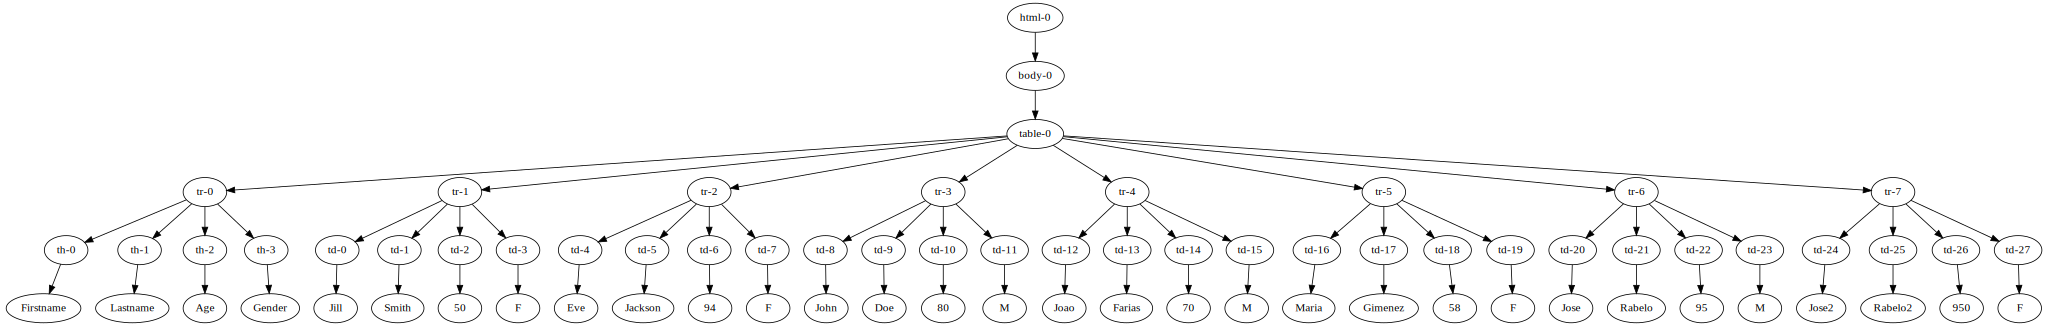

In [113]:
%load_ext autoreload
%autoreload 2
from dev_2 import open_doc, html_to_dot, SEQUENTIAL
folder = '.'
filename = 'tables-1.html'
doc = open_doc(folder, filename)
dot = html_to_dot(doc, name_option=SEQUENTIAL)
# dot.view(filename + '.pdf')
dot

In [114]:
mdr = MDR(max_tag_per_gnode=3, verbose=True)
mdr(doc)

html-0



body-0



table-0
in compare_combinations
	starting_tag (i): 1
		gnode_size (j): 1
 
			>>> if 1 <<<
				left_gnode_start (st): 0
				right_gnode_start (k): 1
 
					>>> if 2 <<<
					left_gnode_indices: (0, 1)
					right_gnode_indices: (1, 2)
					edit_distance: 0.32989690721649484
 
				left_gnode_start (st): 1
				right_gnode_start (k): 2
 
					>>> if 2 <<<
					left_gnode_indices: (1, 2)
					right_gnode_indices: (2, 3)
					edit_distance: 0.15476190476190477
 
				left_gnode_start (st): 2
				right_gnode_start (k): 3
 
					>>> if 2 <<<
					left_gnode_indices: (2, 3)
					right_gnode_indices: (3, 4)
					edit_distance: 0.15476190476190477
 
				left_gnode_start (st): 3
				right_gnode_start (k): 4
 
					>>> if 2 <<<
					left_gnode_indices: (3, 4)
					right_gnode_indices: (4, 5)
					edit_distance: 0.10714285714285714
 
				left_gnode_start (st): 4
				right_gnode_start (k): 5
 
					>>> if 2 <<<
					left_gnode_indices: (4, 5)
					right_gnode_indices: (5, 6)
					e

In [115]:
print(lxml.etree.tostring(doc).decode('utf-8'))

<html>
<body>
<table style="width:100%; text-align: left" ___tag_name___="table-0">
  <tr ___tag_name___="tr-0">
    <th ___tag_name___="th-0">Firstname</th>
    <th ___tag_name___="th-1">Lastname</th>
    <th ___tag_name___="th-2">Age</th>
    <th ___tag_name___="th-3">Gender</th>
  </tr>
  <tr ___tag_name___="tr-1">
    <td ___tag_name___="td-0">Jill</td>
    <td ___tag_name___="td-1">Smith</td>
    <td ___tag_name___="td-2">50</td>
    <td ___tag_name___="td-3">F</td>
  </tr>
  <tr ___tag_name___="tr-2">
    <td ___tag_name___="td-4">Eve</td>
    <td ___tag_name___="td-5">Jackson</td>
    <td ___tag_name___="td-6">94</td>
    <td ___tag_name___="td-7">F</td>
  </tr>
  <tr ___tag_name___="tr-3">
    <td ___tag_name___="td-8">John</td>
    <td ___tag_name___="td-9">Doe</td>
    <td ___tag_name___="td-10">80</td>
    <td ___tag_name___="td-11">M</td>
  </tr>
  <tr ___tag_name___="tr-4">
    <td ___tag_name___="td-12">Joao</td>
    <td ___tag_name___="td-13">Farias</td>
    <td ___tag_n

In [116]:
pprint(mdr.distances)

{'table-0': {1: {1: {((0, 1), (1, 2)): 0.32989690721649484,
                     ((1, 2), (2, 3)): 0.15476190476190477,
                     ((2, 3), (3, 4)): 0.15476190476190477,
                     ((3, 4), (4, 5)): 0.10714285714285714,
                     ((4, 5), (5, 6)): 0.1744186046511628,
                     ((5, 6), (6, 7)): 0.16279069767441862,
                     ((6, 7), (7, 8)): 0.07058823529411765}},
             2: {1: {((0, 2), (2, 4)): 0.23204419889502761,
                     ((2, 4), (4, 6)): 0.15789473684210525,
                     ((4, 6), (6, 8)): 0.14035087719298245},
                 2: {((1, 3), (3, 5)): 0.13690476190476192,
                     ((3, 5), (5, 7)): 0.13450292397660818}},
             3: {1: {((0, 3), (3, 6)): 0.21052631578947367},
                 2: {((1, 4), (4, 7)): 0.12890625},
                 3: {((2, 5), (5, 8)): 0.14396887159533073}}},
 'td-0': {},
 'td-1': {},
 'td-10': {},
 'td-11': {},
 'td-12': {},
 'td-13': {},
 'td-14': {},
 'td